# A quick fix for a common NDBC DODS error
By Sage Lichtenwalner, March 9, 2021

The [NDBC DODS OpenDAP server](https://dods.ndbc.noaa.gov) is a great resource, providing decades of weather and ocean data from hundreds of stations around the globe.  This dataset is a great resource for students interested in accessing a large and intuitive dataset to learn programming and data analysis skills.

Unfortunately, if you try to request a long timeseries from some stations, you might run into the following error:

`RuntimeError: NetCDF: file not found`

If this is the case, here are 2 workarounds that might help.

## The problem

First, let's setup our notebook like we normally do for the Google Colab environment.


In [ ]:
# Notebook setup
import xarray as xr
!pip install netcdf4

import matplotlib.pyplot as plt
# Let's make our plots pretty
import seaborn as sns
sns.set()

Next, let's try to load a full timeseries for Station 44065, which has data that goes back to 2008.

In [ ]:
data = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065.ncml')

In [ ]:
# data['sea_surface_temperature'].plot() # This line will fail

The .ncml file is really an aggregation of the other individual yearly files available for this station ([see here](https://dods.ndbc.noaa.gov/thredds/catalog/data/stdmet/44065/catalog.html)).  For some reason, when you try to load a large time range with the .ncml file, you get the "netcdf file not found error.”

I'm not quite sure if this is because the lat/lon coordinates or another variable changes in the long series, which causes an aggregation issue on the server.

But as unintuitive as the error may be, we can in fact still grab all the data.

## Option 1 - Make a smaller time range request

Bizarrely, and perhaps annoyingly, if you change your date range to a smaller period, it works.  

After a bunch of testing with this station, I found I can request 1/1/2009 to the present without issue.  But as soon as I try to add 2008, I get the error.  But 2008 to a 2-3 months shy of the present day also loads.  This is the kind of inconsistent bug that makes debugging hard.  (But at least in this case the error is consistent.)


In [ ]:
data = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065.ncml')

# data = data.sel(time=slice('2008-01-01','2021-03-30')) # This fails as of 3/9/21
# data = data.sel(time=slice('2009-01-01','2021-03-30')) # Removing the first year works
data = data.sel(time=slice('2008-01-01','2021-01-30')) # Removing the last 1-2 months works
# data = data.sel(time=slice('2008-01-01','2021-02-01')) # But this also fails

df = data.to_dataframe().reset_index().set_index('time') # Convert to dataframe to force loading of the full dataset
df.tail(3)

,latitude,longitude,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
time,,,,,,,,,,,,,,,
2021-01-30 23:30:00,40.368999,-73.703003,299.0,7.7,10.3,NaN,NaT,NaT,NaN,1024.500000,NaN,4.4,NaN,NaN,NaN
2021-01-30 23:40:00,40.368999,-73.703003,304.0,6.9,8.9,1.18,0 days 00:00:12.119999886,0 days 00:00:05.610000134,134.0,1024.599976,NaN,4.4,NaN,NaN,NaN
2021-01-30 23:50:00,40.368999,-73.703003,297.0,6.7,8.8,NaN,NaT,NaT,NaN,1024.800049,NaN,4.4,NaN,NaN,NaN


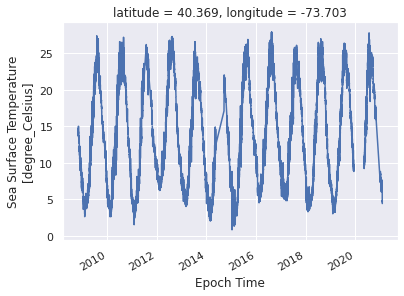

In [ ]:
# Quick plot
data['sea_surface_temperature'].plot();

Let's try the same approach for Station 44025.

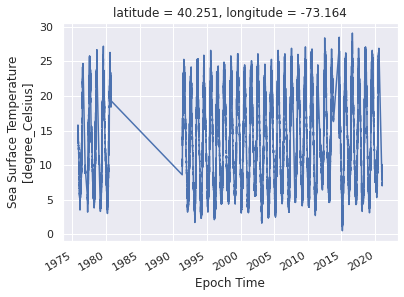

In [ ]:
data = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44025/44025.ncml')

# data = data.sel(time=slice('1975-01-01','2021-03-30')) # This fails as of 3/9/21
# data = data.sel(time=slice('1976-01-01','2021-03-30')) # Removing the first year works
data = data.sel(time=slice('1975-01-01','2021-01-30')) # Removing the last 1-2 months works
# data = data.sel(time=slice('1975-01-01','2021-02-01')) # But this also fails

data.sea_surface_temperature.plot();

So, if you don’t need the full range, you can leave off a year on either end.  Or alternatively, if you can find the offending time breaks, you might be able to make smaller requests and then merge them together.


## Option 2 - Don't use the aggregate ncml file

Another approach that seems to work, is to specify the individual data files using `open_mfdataset()` like this...

In [ ]:
urls = ['https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2008.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2009.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2010.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2011.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2012.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2013.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2014.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2015.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2016.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2017.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2018.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2019.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2020.nc',
        'https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44065/44065h2021.nc',
]

In [ ]:
data = xr.open_mfdataset(urls, combine='by_coords')
df = data.to_dataframe().reset_index().set_index('time')
df.tail(3)

,latitude,longitude,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
time,,,,,,,,,,,,,,,
2021-01-31 23:30:00,40.368999,-73.703003,69.0,8.2,10.5,NaN,NaT,NaT,NaN,1022.799988,NaN,4.2,NaN,NaN,NaN
2021-01-31 23:40:00,40.368999,-73.703003,70.0,8.4,10.1,1.36,0 days 00:00:14.810000420,0 days 00:00:05.820000172,126.0,1022.799988,NaN,4.2,NaN,NaN,NaN
2021-01-31 23:50:00,40.368999,-73.703003,69.0,8.2,10.1,NaN,NaT,NaT,NaN,1022.599976,NaN,4.2,NaN,NaN,NaN


## A Note about Realtime Data
In the examples above, you'll notice that the most recent data available for both stations is from 1/31/2021, even though I'm running this script on 3/9/21.

This is because the "yearly" netcdf files on the DODS server only seem to include "verified" data, which is added to the archive in monthly chunks.  (My guess is that this typically occurs approximately 45 days after the end of each month.)

If you want real-time data, you will need to use the "9999" files available in each station's directory.  Apparently these files include some historic data as well, but how much varies from station to station.  

So, if you want a full archive up to the present day, you'll have to make and merge multiple requests, as these recent/real-time data points are not available through the .ncml aggregation file.

Here's a quick example for Station 44025.  You can see that this file includes several years of data, but nothing like the decades available in the example above.

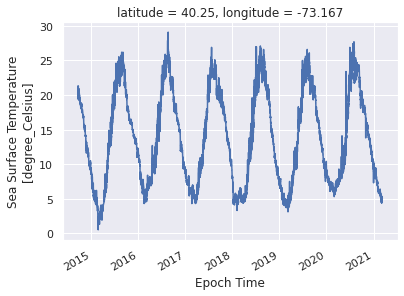

In [ ]:
data = xr.open_dataset('https://dods.ndbc.noaa.gov/thredds/dodsC/data/stdmet/44025/44025h9999.nc')
data.sea_surface_temperature.plot();

In [ ]:
df = data.to_dataframe().reset_index().set_index('time')
df.head(1)

,latitude,longitude,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
time,,,,,,,,,,,,,,,
2014-09-18 19:50:00,40.25,-73.167,240.0,2.0,2.0,0.9,0 days 00:00:12,NaT,NaN,1016.200012,20.200001,21.299999,10.1,NaN,NaN


In [ ]:
df.tail(1)

,latitude,longitude,wind_dir,wind_spd,gust,wave_height,dominant_wpd,average_wpd,mean_wave_dir,air_pressure,air_temperature,sea_surface_temperature,dewpt_temperature,visibility,water_level
time,,,,,,,,,,,,,,,
2021-03-09 17:30:00,40.25,-73.167,240.0,5.0,6.0,NaN,NaT,NaT,NaN,1025.5,NaN,5.1,NaN,NaN,NaN


For more guidance, check out my [Accessing NDBC Data](https://github.com/ooi-data-lab/datalab-blog-examples/blob/master/2020/02_Accessing_NDBC_Data.ipynb) tutorial, as well as the other [Python Examples](https://datalab.marine.rutgers.edu/category/python-examples/) on the Ocean Data Labs site.